# 20200602 Anti-CRISPR enrichment modeling

### Goals of notebook
* use modeling framework to show how developing a new dCas9 was necessary to prevent Anti-CRISPRs from taking over the protease selections

### Parameters of interest
* relative REU values (mapped to relative growth rates)
* different Cm concentrations

$f_{+}(t=0) : \{0.5,10^{-1},10^{-2},10^{-3}\}$

# Validating relative growth rates and plotting growth curves
Need to show that simulating the system with relative growth rates is the same as simulating the system with absolute growth rates. Hard to do this analytically because I can't find a general solution to competitive Lotke-Volterre equations...

Test case: Two species, $x_1$ and $x_2$, with absolute growth rates, $r_1 = 0.25, r_2 = 0.125$, and relative growth rates of $\bar{r_1} = 1, \bar{r_2} = 0.5$.

How does the system evolve over time for each?

In [ ]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import matplotlib
matplotlib.rc('figure', dpi = 125)
sns.set_palette('muted')
sns.set_style('ticks')

import sys
sys.path.append('./modules')
import enrichments

In [ ]:
importlib.reload(enrichments)

In [ ]:
# Define initial values and normalize them to fraction
lib_sz = 1e8
x_i0 = np.array([lib_sz-12,10, 1,1])
x_i0_norm = x_i0/np.sum(x_i0)


# Define absolute rates and relative rates
r_i = np.array([0,0.2,0.5,0.8])
r_i_norm = r_i / np.max(r_i)

dil = 100

sys_1 = enrichments.Growth_tube(x_i0_norm, r_i_norm, dil)
sys_1.sim_growth()

In [ ]:
fig, ax = plt.subplots(figsize = (4,4))

sys_1.plot_x_t(ax)

ax.set_xlabel('Time')
ax.set_ylabel('Normalized abundance')

plt.show()

In [ ]:
print('Enrichment vals:', sys_1.x_t[:,-1])

# Hypothetical enrichments w/ new dCas9 vs antiCRISPR

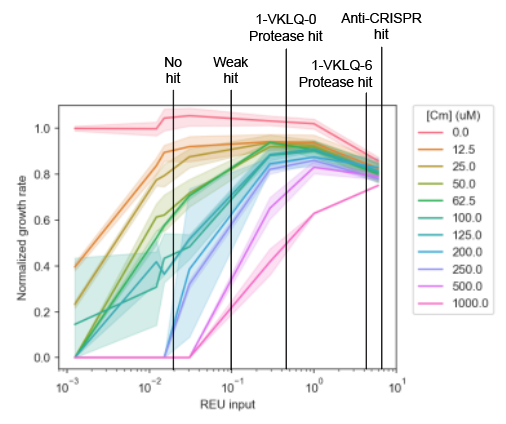

### Hypothetical library

* $10^8$ members
* 10 weak hits
* 1 protease inhibitor
* 1 anti-CRISPR

In [ ]:
# Import df w/ growth rates for each library member eyeballed from plot above
df_growth= pd.read_excel('./anticrispr_growths.xlsx')
df_growth

In [ ]:
# Simulate two different sets of libraries: one w/ the old proCas9, one with the new proCas9
procas9s = ['VKLQ-0_hit', 'VKLQ-6_hit']
cms = df_growth['cm'].unique()

# Create df to store enrichment values
df_enrich = pd.DataFrame(columns = ['strain', 'cm', 'enrich', 'frac', 'procas9_type'])

for procas9 in procas9s:
    # Loop for each value of Cm
    for cm in cms:
        # Get growth rates of everything for give Cm value
        no_hit_gr = df_growth[(df_growth['cm'] == cm) & (df_growth['strain'] == 'no_hit')]['rel_growth'].values[0]
        weak_hit_gr = df_growth[(df_growth['cm'] == cm) & (df_growth['strain'] == 'weak_hit')]['rel_growth'].values[0]
        hit_gr = df_growth[(df_growth['cm'] == cm) & (df_growth['strain'] == procas9)]['rel_growth'].values[0]
        anticrispr_gr = df_growth[(df_growth['cm'] == cm) & (df_growth['strain'] == 'anticrispr_hit')]['rel_growth'].values[0]
        
        # Instantiate library
        lib_sz = 1e8

        x_i0 = np.array([lib_sz-102,100, 1,1])
        x_i0_norm = x_i0/np.sum(x_i0)

        # Define growth rates from data above
        r_i = np.array([no_hit_gr,weak_hit_gr,hit_gr,anticrispr_gr])

        dil = 100
        # Simulate the system
        sys = enrichments.Growth_tube(x_i0_norm, r_i, dil)
        sys.sim_growth()
        
        # retrieve enrichments and add to dataframe
        for i, strain in enumerate(['no_hit', 'weak_hit', procas9, 'anticrispr_hit']):
            enrichment = sys.enrichs[i]
            frac = sys.x_t[i,-1] / np.sum(sys.x_t[:,-1])
            
            new_row = {'strain': strain, 'cm': cm, 'enrich': enrichment, 'frac': frac, 'procas9_type': procas9}
            df_enrich = df_enrich.append(new_row, ignore_index = True)

In [ ]:
df_enrich.head()

In [ ]:
# Plot enrichments

sns.set_style('ticks')
fig, axs = plt.subplots(1,2,figsize = (8,4))
plt.tight_layout(pad = 3)

for procas9, ax in zip(procas9s, axs):
    
    #subset df to only include enrichment results for given procas9
    sub_df = df_enrich[df_enrich['procas9_type'] == procas9]
    
    sns.lineplot(x = 'cm', y = 'enrich', hue = 'strain', data = sub_df, ax = ax)
    
    ax.set_yscale('log')
    ax.set_ylim([1e-3,1e9])
    ax.set_xlabel('Chloramphenicol (uM)')
    ax.set_ylabel('Single-round enrichment')
    ax.legend(['Non hit', 'Weak hit', 'Protease hit', 'Anti-CRISPR'],bbox_to_anchor=(1.05, 1))
    
    if procas9 == 'VKLQ-0_hit':
        ax.set_title('Previous pro-dCas9')
        ax.get_legend().remove()
    else:
        ax.set_title('Tightened linker pro-dCas9')
    
    
plt.show()

In [ ]:
sns.set_style('ticks')
fig, axs = plt.subplots(1,2,figsize = (8,4))
plt.tight_layout(pad = 3)

for procas9, ax in zip(procas9s, axs):
    
    #subset df to only include enrichment results for given procas9
    sub_df = df_enrich[df_enrich['procas9_type'] == procas9]
    
    sns.lineplot(x = 'cm', y = 'frac', hue = 'strain', data = sub_df, ax = ax)
    
    ax.set_yscale('log')
    ax.set_ylim([1e-9,10])
    ax.set_xlabel('Chloramphenicol (uM)')
    ax.set_ylabel('Fractions after one round')
    ax.legend(['Non hits', 'Weak hits', 'Protease hit', 'Anti-CRISPR'],bbox_to_anchor=(1.05, 1))
    
    if procas9 == 'VKLQ-0_hit':
        ax.set_title('Previous pro-dCas9')
        ax.get_legend().remove()
    else:
        ax.set_title('Tightened linker pro-dCas9')
    
plt.show()

## Next steps
* simulate rounds?
* simulate negative selections for anti-crisprs?